# Imports and parameters

In [28]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.constants as const
from astropy.wcs import WCS
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from minot.model_tools import trapz_loglog
from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
#---------- Analysis
Nmc         = 10          # Number of Monte Carlo trials
reset_mcmc  = True        # Should we restart the MCMC or use existing chains

#---------- Data
redshift    = 0.0179          # Perseus redshift
tmax_integ0 = 15.0/2*u.arcmin # Radius up to which the flux is integrated (15' == extend, i.e. diameter)
Rmin_prof0  = 30*u.kpc        # Radius down to which the model is acceptable (due to NGC1275)
freq0       = 327*u.MHz       # Frequency at which the profile is extracted
idx_freq1   = 327*u.MHz       # Start frequency for spectral index calculation
idx_freq2   = 609*u.MHz       # End frequency for spectral index calculation

#---------- Model
# Magnetic field
B_eta     = 0.6      # Scaling with respect to base quantity
B_scaling = 'N'      # Quantity used for scaling
B_norm    = 25*u.uG  # Normalization of the magnetic field
B_rnorm   = 10*u.kpc # Radius of normalization

# CR
CR_eta     = 2.0      # Scaling with respect to base quantity
CR_scaling = 'N'      # Quantity used for scaling

# Data

In [3]:
#----- Directory
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')+'Radio'

In [4]:
#----- Cosmology correction
cosmo_paper = FlatLambdaCDM(H0=50, Om0=0.3) # Omega_m is in fact not given in the paper, but very small effect at Perseus redshift
distance_correction = (cosmo.kpc_proper_per_arcmin(redshift)/cosmo_paper.kpc_proper_per_arcmin(redshift)).to_value('')
print('Distance correction:', distance_correction)
print('My cosmo: ',cosmo.kpc_proper_per_arcmin(redshift))
print("Gitti's cosmo: ", cosmo_paper.kpc_proper_per_arcmin(redshift))

('Distance correction:', 0.7380270206765911)
('My cosmo: ', <Quantity 22.54434773 kpc / arcmin>)
("Gitti's cosmo: ", <Quantity 30.54677824 kpc / arcmin>)


In [5]:
#----- Profile
# Extracted from Gitti's paper
prof_file = dat_dir+'/Perseus_radio_profile_Gitti.txt' 
prof_data1 = pd.read_csv(prof_file, header=None, skiprows=1, index_col=False, names=['radius', 'flux', 'error_m', 'error_p'])
prof_data1['error_m'] = np.log(10)*10**prof_data1['flux'] * prof_data1['error_m'] / 2
prof_data1['error_p'] = np.log(10)*10**prof_data1['flux'] * prof_data1['error_p'] / 2
prof_data1['flux'] = 10**prof_data1['flux']

# Provided by G.F.B.
prof_data2 = {'radius':np.array([239.2,217.8,203.5,192.8,185.7,167.8,153.5,139.2,128.5,110.7,092.8,082.1,067.8,053.6,042.8,039.3,028.6,014.3]), 
             'flux_m':np.array([0.003667,0.003667,0.003643,0.007334,0.011000,0.018340,0.036670,0.036670,0.055010,0.073340,0.073340,0.183400,0.366700,0.550100,0.733400,0.733400,3.667000,14.66800]),
             'flux_p':np.array([0.036670,0.036670,0.018340,0.055010,0.055010,0.091680,0.183400,0.366700,0.366700,0.550100,0.550100,0.733400,0.733400,1.375100,3.667000,3.667000,7.334100,14.66800])}
prof_data2['flux']    = 0.5*(prof_data2['flux_m'] + prof_data2['flux_p'])
prof_data2['error_m'] =  (prof_data2['flux'] - prof_data2['flux_m'])
prof_data2['error_p'] = -(prof_data2['flux'] - prof_data2['flux_p'])

# Combinaning the two
prof_data = {'radius':prof_data2['radius'][::-1]*u.kpc*distance_correction,
             'flux':np.array(prof_data1['flux'])*u.Jy/u.arcmin**2,
             'error_p':np.abs(prof_data2['flux_p'][::-1] - np.array(prof_data1['flux']))*u.Jy/u.arcmin**2,
             'error_m':np.abs(prof_data2['flux_m'][::-1] - np.array(prof_data1['flux']))*u.Jy/u.arcmin**2,
             #'error':0.5*(prof_data2['flux_p'][::-1] - prof_data2['flux_m'][::-1])*u.Jy/u.arcmin**2,
             'error':np.array(prof_data1['flux'])*u.Jy/u.arcmin**2 / 3.0,
             'freq0':freq0,
             'Rmin':Rmin_prof0*distance_correction}

In [6]:
#----- Spectrum
spec_data = {'freq':np.array([327,609,1395])*u.MHz, 
             'flux':np.array([1.2423625254582,0.8798370672098,0.4765784114053]), # This is log F/Jy here
             'error':np.array([0.12219959266803,0.08961303462322,0.05702647657841]),
             'Rmin':Rmin_prof0*distance_correction,
             'Rmax':(tmax_integ0*cosmo.kpc_proper_per_arcmin(redshift)).to('kpc')}

spec_data['error'] = np.log(10)*10**spec_data['flux'] * spec_data['error'] * u.Jy
spec_data['flux'] = 10**spec_data['flux'] *u.Jy

In [7]:
#----- Spectral index
idx_data = {'radius':np.array([27,46,70,123,169])*u.kpc*distance_correction, 
            'idx':np.array([1.10,1.25,1.55,1.9,2.15]),
            'error':np.array([0.0, 0.125, 0.125, 0.125, 0.125]),
            'freq1':idx_freq1,
            'freq2':idx_freq2,
            'Rmin':Rmin_prof0*distance_correction}

43.2393202105 Jy
(<Quantity 327. MHz>, <Quantity 327. MHz>, <Quantity 17.47280079 Jy>)
('flux correcction', <Quantity 2.47466452>)


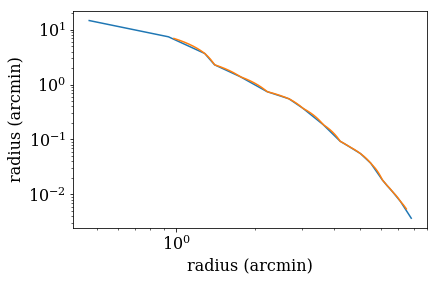

In [8]:
#----- Check the data consistency
# Interpolate the data over a requested range
t_itpl = np.logspace(np.log10((spec_data['Rmin']/cosmo.kpc_proper_per_arcmin(redshift)).to_value('arcmin')),
                     np.log10((spec_data['Rmax']/cosmo.kpc_proper_per_arcmin(redshift)).to_value('arcmin')),
                     1000)
itpl = interp1d((prof_data['radius']/cosmo.kpc_proper_per_arcmin(redshift)).to_value('arcmin'), 
                prof_data['flux'].to_value('Jy arcmin-2'), 
                kind='linear', fill_value='extrapolate')
p_itpl = itpl(t_itpl)

# Check the interpolation
plt.loglog((prof_data['radius']/cosmo.kpc_proper_per_arcmin(redshift)).to_value('arcmin'), 
           prof_data['flux'].to_value('Jy arcmin-2'))
plt.loglog(t_itpl, p_itpl)
plt.xlabel('radius (arcmin)')
plt.ylabel('radius (arcmin)')

# Compute the flux expected from the profile
flux_from_profile = trapz_loglog(2*np.pi*t_itpl*p_itpl, t_itpl)*u.Jy
flux_correction_factor = flux_from_profile/spec_data['flux'][0]

# Compare to the spectrum
print(flux_from_profile)
print(prof_data['freq0'], spec_data['freq'][0], spec_data['flux'][0])
print('flux correcction',flux_correction_factor)

In [9]:
prof_data['error'] = prof_data['error']/flux_correction_factor
prof_data['flux']  = prof_data['flux']/flux_correction_factor

# Define the cluster model

In [10]:
cluster = minot.Cluster(name='Perseus', redshift=redshift, M500=6.2e14*u.Msun, cosmology=cosmo, silent=True)
cluster.coord = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')
cluster.output_dir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Thermodynamics (from Churazov 2003 and my own Planck map fit)
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*distance_correction, 'n_01':3.9e-2*u.cm**-3*distance_correction**-0.5,
                             'beta2':0.58, 'r_c2':280*u.kpc*0.73, 'n_02':4.05e-3*u.cm**-3*distance_correction**-0.5}
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':0.0026*u.keV/u.cm**3, 'r_p':1088*u.kpc,
                              'a':2.74, 'b':4.21, 'c':0.52}
# CRe1
if CR_scaling == 'N':
    r, ng = cluster.get_density_gas_profile(radius=np.logspace(-1,5,1000)*u.kpc)
    cluster._density_cre1_model = {'name':'User', 'radius':r, 'profile':ng.to_value('cm-3')**CR_eta*u.adu}
elif CR_scaling == 'P':
    cluster.set_density_cre1_isobaric_scal_param(scal=CR_eta)
else:
    raise('ERROR with the CR scaling')
cluster.spectrum_cre1_model = {'name': 'ExponentialCutoffPowerLaw', 'Index': -2.0, 'CutoffEnergy':0.23*u.GeV}
cluster.X_cre1_E = {'X':7e-7, 'R_norm':cluster.R500}

# CRp
if CR_scaling == 'N':
    r, ng = cluster.get_density_gas_profile(radius=np.logspace(-1,5,1000)*u.kpc)
    cluster.density_crp_model = {'name':'User', 'radius':r, 'profile':ng.to_value('cm-3')**CR_eta}
elif CR_scaling == 'P':
    cluster.set_density_crp_isobaric_scal_param(scal=CR_eta)
else:
    raise('ERROR with the CR scaling')
cluster.spectrum_crp_model = {'name': 'PowerLaw', 'Index': 2.3}
cluster.X_crp_E = {'X':0.0, 'R_norm':cluster.R500}

# B field strenght
if B_scaling == 'N':
    cluster.set_magfield_isodens_scal_param(Bnorm=1*u.uG, r0=B_rnorm, scal=1.0)
    r, B = cluster.get_magfield_profile(radius=np.logspace(-1,5,1000)*u.kpc)
    r_ref, B_ref = cluster.get_magfield_profile(B_rnorm)
    cluster.magfield_model = {'name':'User', 'radius':r, 'profile':B_norm*(B/B_ref[0])**B_eta}
elif B_scaling == 'P':
    cluster.set_magfield_isobaric_scal_param(Bnorm=1*u.uG, r0=B_rnorm, scal=B_eta)
    r_ref, B_ref = cluster.get_magfield_profile(B_rnorm)
    cluster.set_magfield_isobaric_scal_param(Bnorm=1*u.uG/B_ref*B_norm, r0=B_rnorm, scal=B_eta)
else:
    raise('ERROR with the magnetic field scaling')

# Sampling
cluster.Npt_per_decade_integ = 10

# Data initial model comparison

In [11]:
#----- Spectrum
model_ini_freq, model_ini_spec = cluster.get_synchrotron_spectrum(frequency=np.logspace(0,5,50)*u.MHz, 
                                                                  Rmin=prof_data['Rmin'], 
                                                                  Rmax=spec_data['Rmax'], 
                                                                  type_integral='cylindrical', Cframe=False)

#----- Profile
model_ini_rad,  model_ini_prof = cluster.get_synchrotron_profile(radius=np.logspace(0,3,50)*u.kpc, 
                                                                 freq0=prof_data['freq0'], Cframe=True)

#----- Index
model_ini_idxrad, model_ini_idx1 = cluster.get_synchrotron_profile(radius=np.logspace(0,3,50)*u.kpc, 
                                                                 freq0=idx_data['freq1'])
model_ini_idxrad, model_ini_idx2 = cluster.get_synchrotron_profile(radius=np.logspace(0,3,50)*u.kpc, 
                                                                 freq0=idx_data['freq2'])
model_ini_idx = -np.log10((model_ini_idx1/model_ini_idx2).to_value('')) / np.log10((idx_data['freq1']/idx_data['freq2']).to_value(''))

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


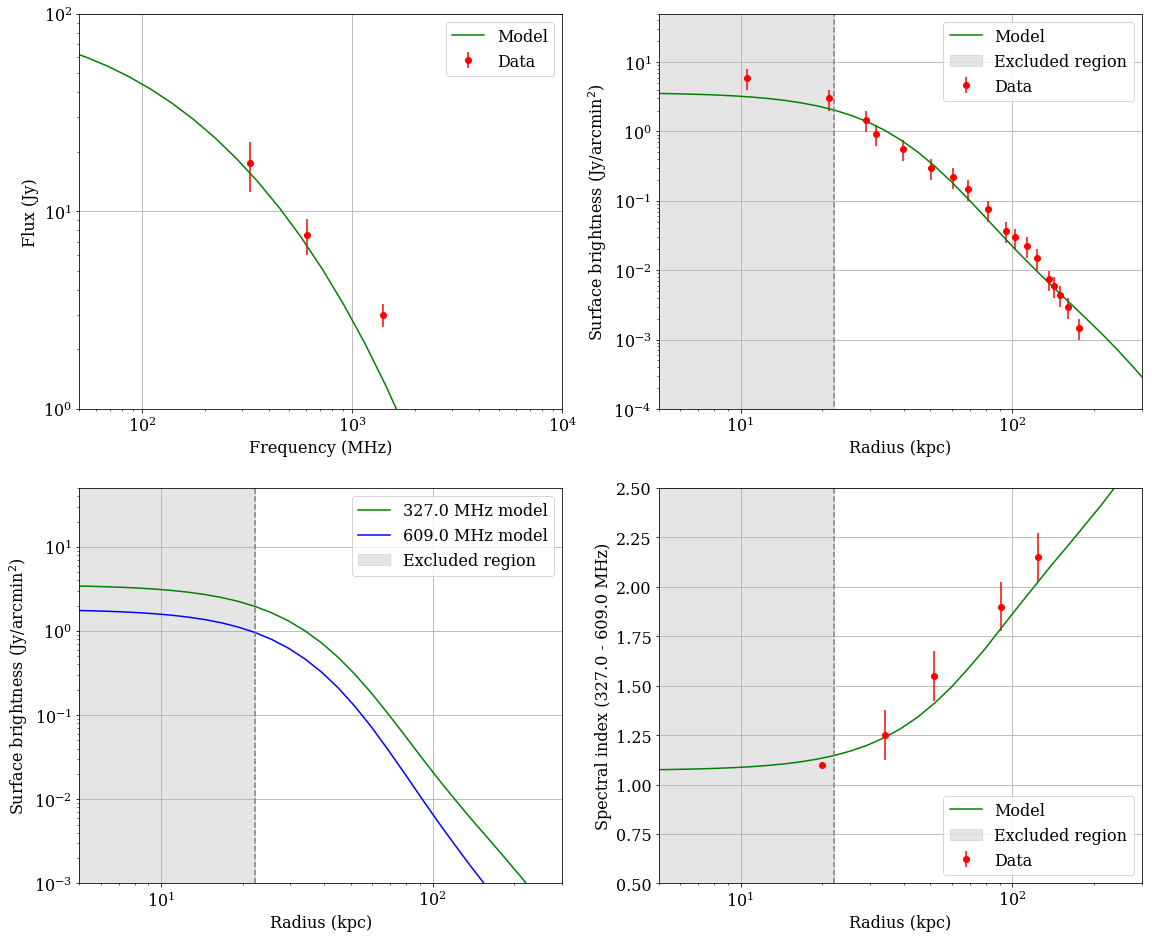

In [12]:
#----- Spectrum
fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_freq.to_value('MHz'), model_ini_spec.to_value('Jy'), color='green', label='Model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.xlim(50,10000)
plt.ylim(1,100)
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(222)
#plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
#             yerr=(prof_data['error_m'].to_value('Jy arcmin-2'), prof_data['error_p'].to_value('Jy arcmin-2')),
#             marker='o', linestyle='', color='k')
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=prof_data['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_rad.to_value('kpc'),  model_ini_prof.to_value('Jy arcmin-2'), color='green', label='Model')
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,prof_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-4,50)
plt.legend()
plt.grid()

#----- Profile versus frequency
ax = plt.subplot(223)
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx1.to_value('Jy arcmin-2'), color='green', label=str(idx_data['freq1'].to_value('MHz'))+' MHz model')
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx2.to_value('Jy arcmin-2'), color='blue', label=str(idx_data['freq2'].to_value('MHz'))+' MHz model')
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-3,50)
plt.legend()
plt.grid()

#----- Spectral index
ax = plt.subplot(224)
plt.errorbar(idx_data['radius'].to_value('kpc'), idx_data['idx'], yerr=idx_data['error'],
             marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx, color='green', label='Model')
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index ('+str(idx_data['freq1'].to_value('MHz'))+' - '+str(idx_data['freq2'].to_value('MHz'))+' MHz)')
plt.xlim(5,300)
plt.ylim(0.5,2.5)
plt.legend()
plt.grid()

plt.savefig(cluster.output_dir+'/ResultsCR_test_model')

# MCMC fit

In [13]:
#----- Defines log likelihood
def lnlike(params, cluster, pdata, sdata, idata):
    #--- Priors
    cond1 = params[0]>=0 and params[0]<=1.0
    cond2 = params[1]>=-10 and params[1]<=10
    cond3 = params[2]>=1e-3 and params[3]<=1e6
    cond4 = params[3]>=-4 and params[3]<=0
    cond5 = params[4]>=0 and params[4]<=3
    if cond1 and cond2 and cond3 and cond4 and cond5:
        prof_mod, spec_mod, idx_mod = model(params, cluster, pdata, sdata, idata)
        
        # Profile chi2
        wgood = pdata['radius'] > pdata['Rmin']
        prof_chi2 = ((pdata['flux'].to_value('Jy arcmin-2')[wgood] - prof_mod.to_value('Jy arcmin-2')[wgood])**2)/pdata['error'].to_value('Jy arcmin-2')[wgood]**2

        # Spectrum chi2
        spec_chi2 = ((sdata['flux'].to_value('Jy') - spec_mod.to_value('Jy'))**2)/sdata['error'].to_value('Jy')**2

        # Spectral index chi2
        wgood = idata['radius'] > idata['Rmin']
        idx_chi2 = ((idata['idx'][wgood] - idx_mod[wgood])**2)/idata['error'][wgood]**2
        
        return -0.5*np.nansum(prof_chi2) - 0.5*np.nansum(spec_chi2) - 0.5*np.nansum(idx_chi2)
    else:
        #print('Prior conditions are ', cond1, cond2, cond3, cond4, cond5)
        return -np.inf

In [14]:
#----- Defines model
def model(params, cluster, pdata, sdata, idata):
    #--- Extract parameters
    CR_X_E   = params[0]
    CR_scal  = params[1]
    CR_Eb    = params[2]
    CR_index = params[3]
    B_scal   = params[4]
    
    #--- Set parameters
    cluster.spectrum_cre1_model['CutoffEnergy'] = CR_Eb*u.GeV
    cluster.spectrum_cre1_model = {'name': 'ExponentialCutoffPowerLaw', 'Index': CR_index, 'CutoffEnergy':CR_Eb*u.GeV}
    cluster.X_cre1_E = {'X':CR_X_E, 'R_norm':cluster.R500}
        
    if CR_scaling == 'N':
        r, ng = cluster.get_density_gas_profile(radius=np.logspace(-1,5,1000)*u.kpc)
        cluster._density_cre1_model = {'name':'User', 'radius':r, 'profile':ng.to_value('cm-3')**CR_scal*u.adu}
    elif CR_scaling == 'P':
        cluster.set_density_cre1_isobaric_scal_param(scal=CR_scal)
        
    if B_scaling == 'N':
        cluster.set_magfield_isodens_scal_param(Bnorm=1*u.uG, r0=B_rnorm, scal=1.0)
        r, B = cluster.get_magfield_profile(radius=np.logspace(-1,5,1000)*u.kpc)
        r_ref, B_ref = cluster.get_magfield_profile(B_rnorm)
        cluster.magfield_model = {'name':'User', 'radius':r, 'profile':B_norm*(B/B_ref[0])**B_scal}
    elif B_scaling == 'P':
        cluster.set_magfield_isobaric_scal_param(Bnorm=1*u.uG, r0=B_rnorm, scal=B_scal)
        r_ref, B_ref = cluster.get_magfield_profile(B_rnorm)
        cluster.set_magfield_isobaric_scal_param(Bnorm=1*u.uG/B_ref*B_norm, r0=B_rnorm, scal=B_scal)

    #--- Profile
    r_synch, p_synch = cluster.get_synchrotron_profile(pdata['radius'], freq0=pdata['freq0'])
    
    #--- Spectrum
    sfreq_bis = np.append(np.array([1]), spec_data['freq'].to_value('MHz'))*u.MHz
    f_synch, s_synch = cluster.get_synchrotron_spectrum(sfreq_bis, Rmin=prof_data['Rmin'],
                                                        Rmax=spec_data['Rmax'], type_integral='cylindrical')
    s_synch = s_synch[1:]
    
    #--- Spectral index
    bid, p_synch1 = cluster.get_synchrotron_profile(idata['radius'], freq0=idata['freq1'])
    bid, p_synch2 = cluster.get_synchrotron_profile(idata['radius'], freq0=idata['freq2'])
    i_synch = -np.log10((p_synch1/p_synch2).to_value('')) / np.log10((idata['freq1']/idata['freq2']).to_value(''))
        
    return p_synch, s_synch, i_synch

In [15]:
#----- Define the MCMC
par0 = np.array([2.1902837934510484e-06, 1.6708343761899527, 0.2587671097182398, -2.13500381046448, 0.788083775779008])

param_name = ['X', 's', 'Ebreak', 'idx', 'Bscal']
ndim, nwalkers, nsteps, burnin = len(par0), 10, 1000, 200
pos = [par0 + par0*1e-1*np.random.randn(ndim) for i in range(nwalkers)]

In [16]:
#----- Define the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike,     
                                args=[cluster, prof_data, spec_data, idx_data], pool=Pool(cpu_count()))

#----- Restart from where it is or reset
if reset_mcmc:
    sampler.reset()
else:
    try:
        pos = sampler.chain[:,-1,:]
    except:
        print('No sampler available, restart')
        
#----- Rune the MCMC
sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]


State([[ 1.30460351e-05  1.10062266e+00  2.89858391e-01 -1.94472692e+00
   9.19550345e-01]
 [ 9.38059936e-06  1.23881292e+00  3.89499811e-01 -1.22632405e+00
   9.85179972e-01]
 [ 5.55724817e-06  1.41438862e+00  3.06428229e-01 -1.50994260e+00
   8.55147748e-01]
 [ 1.05723805e-06  1.85100516e+00  2.13825219e-01 -2.82599785e+00
   6.90723173e-01]
 [ 1.75588934e-06  1.76241646e+00  2.55353640e-01 -1.96715531e+00
   7.51282698e-01]
 [ 9.04745111e-06  1.21554936e+00  2.51604827e-01 -2.36077310e+00
   8.70751988e-01]
 [ 1.46203050e-05  1.17776094e+00  3.71240500e-01 -7.17252041e-01
   9.13398719e-01]
 [ 5.48053292e-06  1.38240393e+00  2.93184994e-01 -1.35496518e+00
   8.25555563e-01]
 [ 2.57987798e-06  1.66227074e+00  3.15544651e-01 -1.35079560e+00
   7.98861635e-01]
 [ 1.23341664e-05  1.26163357e+00  4.03686022e-01 -3.90775487e-01
   9.21114629e-01]], log_prob=[-13.72637948 -14.91841037 -11.31911797 -13.30017097 -12.41716412
 -13.40862897 -10.90487534 -12.92515876 -13.66288754 -10.42656483],

In [17]:
#----- Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [18]:
#----- Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
param_best = []
for i in range(ndim):
    param_best.append(((param_chains[:,:,i])[wbest])[0])

In [19]:
#----- MC parameters
param_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2])
Nsample = len(param_flat[:,0])-1
param_MC = np.zeros((Nmc, ndim))
for i in range(Nmc):
    param_MC[i,:] = param_flat[np.random.randint(0, high=Nsample), :] # randomly taken from chains

# Result

### Chains

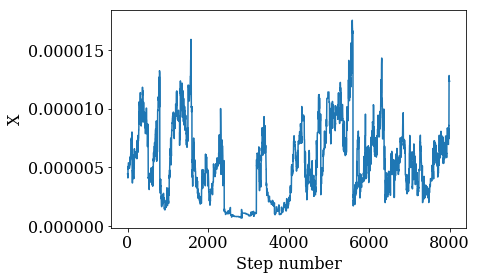

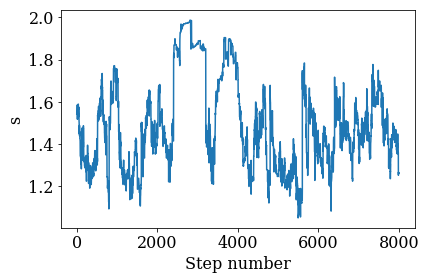

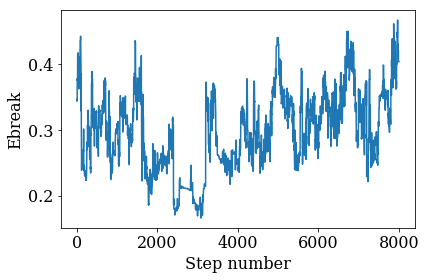

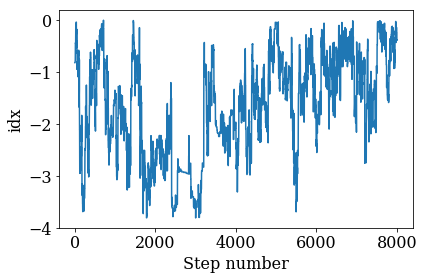

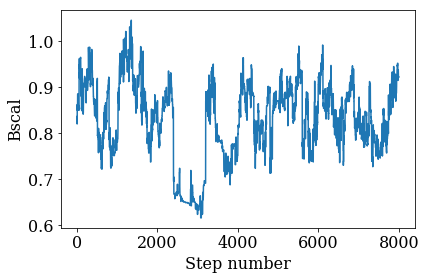

In [20]:
for i in range(ndim):
    plt.figure(i)
    plt.plot((param_chains[:,:,i]).flatten())
    plt.xlabel('Step number')
    plt.ylabel(param_name[i])

### Parameters

In [21]:
print(param_best)

[1.2334166408736297e-05, 1.2616335709765365, 0.4036860221094957, -0.39077548666078443, 0.9211146292827463]


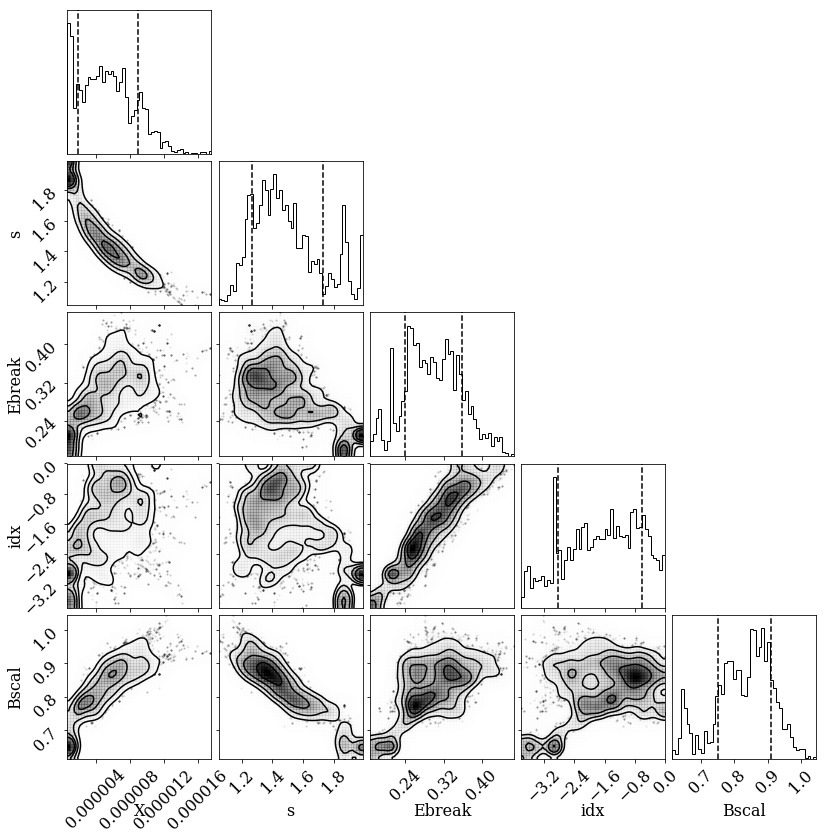

In [22]:
#----- Parameter space
par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
fig = corner.corner(par_flat, bins=50, color='k', smooth=2, labels=param_name, quantiles=(0.16, 0.84))

### Data versus best-fit

In [23]:
prof_best, spec_best, idx_best = model(param_best, cluster, prof_data, spec_data, idx_data)

In [24]:
prof_mc = []
spec_mc = []
idx_mc  = []

for imc in range(Nmc):
    prof_mci, spec_mci, idx_mci = model(param_MC[imc,:], cluster, prof_data, spec_data, idx_data)
    prof_mc.append(prof_mci)
    spec_mc.append(spec_mci)
    idx_mc.append(idx_mci)

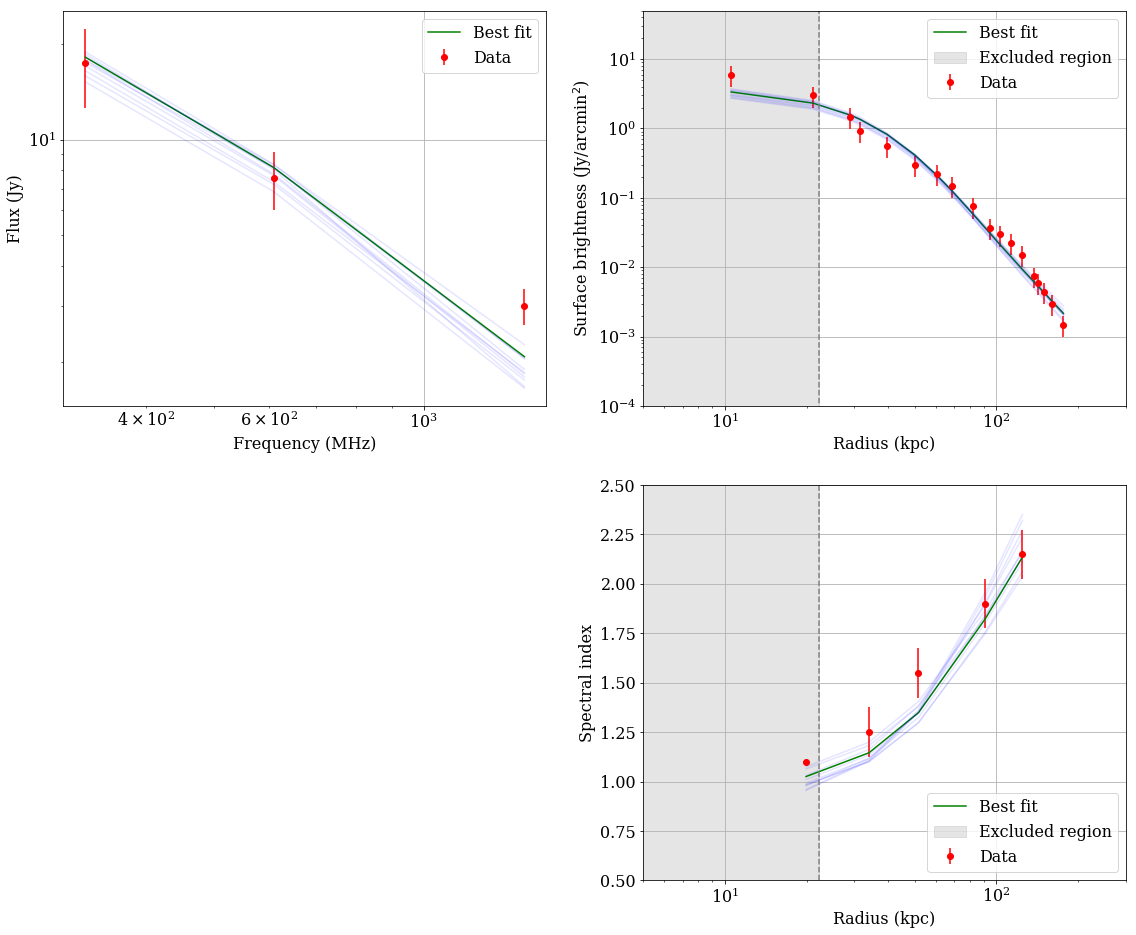

In [25]:
fig = plt.figure(0, figsize=(18, 16))

#----- Spectrum
ax = plt.subplot(221)
plt.errorbar(spec_data['freq'].to_value('MHz'), spec_data['flux'].to_value('Jy'), spec_data['error'].to_value('Jy'),
            marker='o', color='red', linestyle='', label='Data')
plt.plot(spec_data['freq'].to_value('MHz'), spec_best.to_value('Jy'), color='green', label='Best fit')
for imc in range(Nmc):
    plt.plot(spec_data['freq'].to_value('MHz'), spec_mc[imc].to_value('Jy'), color='blue', alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(222)
plt.errorbar(prof_data['radius'].to_value('kpc'), prof_data['flux'].to_value('Jy arcmin-2'), 
             yerr=prof_data['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data')
plt.plot(prof_data['radius'].to_value('kpc'), prof_best.to_value('Jy arcmin-2'), color='green', label='Best fit')
for imc in range(Nmc):
    plt.plot(prof_data['radius'].to_value('kpc'), prof_mc[imc].to_value('Jy arcmin-2'), color='blue', alpha=0.1)
plt.plot([prof_data['Rmin'].to_value('kpc'),prof_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-4,50)
plt.legend()
plt.grid()

#----- Spectral index
ax = plt.subplot(224)
plt.errorbar(idx_data['radius'].to_value('kpc'), idx_data['idx'], yerr=idx_data['error'],
             marker='o', linestyle='', color='red', label='Data')
plt.plot(idx_data['radius'].to_value('kpc'), idx_best, color='green', label='Best fit')
for imc in range(Nmc):
    plt.plot(idx_data['radius'].to_value('kpc'), idx_mc[imc], color='blue', alpha=0.1)
plt.plot([idx_data['Rmin'].to_value('kpc'),idx_data['Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,idx_data['Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index')
plt.xlim(5,300)
plt.ylim(0.5,2.5)
plt.legend()
plt.grid()

# Implications for the gamma-rays

In [26]:
E, dN_dEdSdt = cluster.get_gamma_spectrum(energy=np.logspace(-2,6,100)*u.GeV, 
                                          Rmin=None, Rmax=None,
                                          type_integral='cylindrical',
                                          Rmin_los=None, NR500_los=5.0)
r, dN_dSdtdO = cluster.get_gamma_profile(radius=np.logspace(0,4,100)*u.kpc, 
                                         Emin=50*u.GeV, Emax=100*u.TeV, 
                                         Energy_density=False, Rmin_los=None, NR500_los=5.0)

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


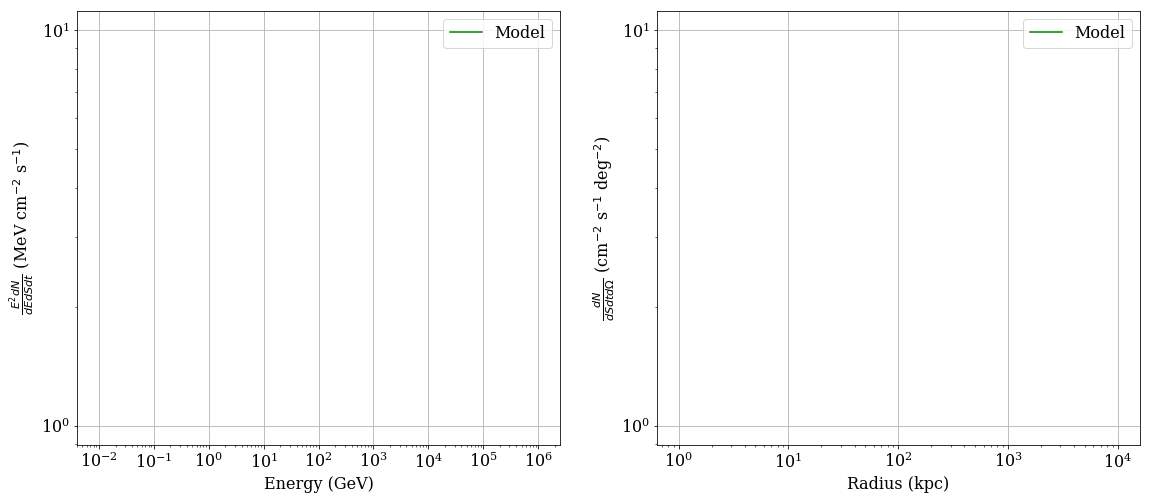

In [27]:
#----- Spectrum
fig = plt.figure(0, figsize=(18, 8))
ax = plt.subplot(121)
plt.plot(E.to_value('GeV'), (E**2*dN_dEdSdt).to_value('MeV cm-2 s-1'), color='green', label='Model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{E^2 dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
#plt.xlim(50,10000)
#plt.ylim(1,100)
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(122)
plt.plot(r.to_value('kpc'), (dN_dSdtdO).to_value('cm-2 s-1 deg-2'), color='green', label='Model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
#plt.xlim(50,10000)
#plt.ylim(1,100)
plt.legend()
plt.grid()